In [1]:
%matplotlib inline

import csv
import os
import json
import numpy as np
import scipy
import scipy.stats
import seaborn as sns
import pandas as pd
import itertools
import sklearn.metrics
from collections import defaultdict

In [2]:
EXCLUDE_PLAYERS = set([
    'debug2II1XV:debug8OX2HI',
    'A1AK9D1SN4YFF3:3R5F3LQFV2KC53TNCW558SS1SG1OZ0',
    'AIZTLQM7HHQN6:3JJVG1YBEBXUFVKP13XR0E2PNJK5BP',
    # 'A26LOVXF4QZZCO:324G5B4FB388ICVYRGFZEHK2NLL07G', # Maybe, since they are "quick" to jump to conclusion
])
HUMAN_DATAFILE = os.path.join('data', 'trialdata.csv')

def load_human_data(filename, match=lambda x: x not in EXCLUDE_PLAYERS):
    result = []
    # returns a map from participant ID to their results
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            player_id = line[0]
            if not match(player_id):
                continue

            data = json.loads(line[3])
            if 'id' not in data or 'results' not in data:
                continue
            
            for stage, d in enumerate(data['results']):
                result.append({
                    'player': player_id,
                    'game': data['id'],
                    'stage': stage,
                    'p1': d[0] / 100,
                    'p2': d[1] / 100,
                    'p3': d[2] / 100
                })
            
    return pd.DataFrame(result, columns=['player', 'game', 'stage', 'p1', 'p2', 'p3'])

DATA = load_human_data(HUMAN_DATAFILE)

In [3]:
# Normalize the data so we have both options

R_DATA = DATA.copy()
N_DATA = DATA.copy()
s = N_DATA.p1 + N_DATA.p2 + N_DATA.p3
N_DATA.p1 /= s
N_DATA.p2 /= s
N_DATA.p3 /= s

In [12]:
from proposal_game import load_games, ProposalGame, create_playthrough
from observer import observe_playthrough
from solver import Solver
GAMES = load_games()

VALID_GAMES = R_DATA.game.unique()

print ', '.join(map(str, VALID_GAMES))

for game_id in VALID_GAMES:
    g = GAMES[game_id]
    if g[0].result != 'success' or g[1].result != 'success' or g[2].result != 'success':
        continue
    print game_id, g

25, 139, 68, 60, 98, 36, 32, 33, 74, 132, 106, 77, 103, 112, 108, 107, 100, 62, 61, 131, 44, 42, 94, 39, 130, 109, 38, 102, 96, 79, 114
139 [Round(number=1, proposal=[1, 3], result=u'success'), Round(number=2, proposal=[2, 3], result=u'success'), Round(number=3, proposal=[2, 3], result=u'success')]


In [20]:
def run_analysis((k, gamma)):
    print (k, gamma)
    game = ProposalGame
    result = []
    solver = Solver(game, gamma=gamma)
    for game_id in VALID_GAMES:
        rounds = GAMES[game_id]
        playthrough = create_playthrough(rounds)
        observations = observe_playthrough(solver, playthrough, k)
        for stage, d in enumerate(observations):
            result.append({
                'k': k,
                'gamma': gamma,
                'game': game_id,
                'stage': stage,
                'p1': d[0],
                'p2': d[1],
                'p3': d[2]
            })
    return pd.DataFrame(result, columns=['k', 'gamma', 'game', 'stage', 'p1', 'p2', 'p3'])

In [22]:
import multiprocessing
arguments = list(itertools.product(range(6), np.arange(0.5, 10.1, 0.5)))

pool = multiprocessing.Pool()
results = pool.map(run_analysis, arguments)
pool.close()
pool.join()

MODEL_PREDICTIONS = pd.concat(results)

(0, 4.5)
(1, 0.5)
(0, 6.5)
(0, 8.5)
(1, 4.5)
(1, 2.5)
(0, 2.5)
(0, 0.5)
(0, 7.0)
(0, 9.0)
(0, 3.0)
(0, 5.0)
(0, 1.0)
(0, 7.5)
(0, 9.5)
(0, 3.5)
(0, 5.5)
(0, 1.5)
(0, 4.0)
(0, 8.0)
(0, 10.0)
(0, 6.0)
(0, 2.0)
(1, 6.5)
(1, 8.5)
(2, 0.5)
(2, 4.5)
(2, 2.5)
(1, 3.0)
(1, 1.0)
(1, 5.0)
(1, 9.0)
(1, 7.0)
(1, 1.5)
(1, 5.5)
(1, 3.5)
(1, 9.5)
(1, 7.5)
(1, 4.0)
(1, 2.0)
(1, 6.0)
(1, 8.0)
(1, 10.0)
(2, 6.5)
(2, 8.5)
(3, 0.5)
(3, 2.5)
(3, 4.5)
(2, 1.0)
(2, 3.0)
(2, 5.0)
(2, 7.0)
(2, 9.0)
(2, 3.5)
(2, 5.5)
(2, 1.5)
(2, 7.5)
(2, 9.5)
(2, 4.0)
(2, 6.0)
(2, 2.0)
(3, 1.0)
(3, 3.0)
(3, 5.0)
(2, 8.0)
(2, 10.0)
(3, 6.5)
(3, 8.5)
(4, 0.5)
(4, 2.5)
(4, 4.5)
(3, 1.5)
(3, 3.5)
(3, 5.5)
(3, 7.0)
(3, 9.0)
(3, 2.0)
(3, 6.0)
(3, 4.0)
(4, 1.0)
(3, 7.5)
(3, 9.5)
(4, 3.0)
(4, 5.0)
(4, 6.5)
(4, 8.5)
(5, 0.5)
(3, 8.0)
(3, 10.0)
(4, 1.5)
(5, 2.5)
(5, 4.5)
(4, 3.5)
(4, 5.5)
(4, 7.0)
(4, 9.0)
(4, 2.0)
(5, 1.0)
(4, 6.0)
(4, 4.0)
(4, 9.5)
(4, 7.5)
(5, 3.0)
(5, 5.0)
(5, 6.5)
(5, 8.5)
(4, 10.0)
(4, 8.0)
(5, 1.5)
(5, 3.5)
(5, 5

In [25]:
MODEL_PREDICTIONS.reset_index(drop=True, inplace=True)
MODEL_PREDICTIONS

,k,gamma,game,stage,p1,p2,p3
0,0,0.5,25,0,3.333333e-01,3.333333e-01,3.333333e-01
1,0,0.5,25,1,5.000000e-01,5.000000e-01,0.000000e+00
2,0,0.5,25,2,5.000000e-01,5.000000e-01,0.000000e+00
3,0,0.5,25,3,0.000000e+00,1.000000e+00,0.000000e+00
4,0,0.5,25,4,0.000000e+00,1.000000e+00,0.000000e+00
5,0,0.5,25,5,0.000000e+00,1.000000e+00,0.000000e+00
6,0,0.5,139,0,3.333333e-01,3.333333e-01,3.333333e-01
7,0,0.5,139,1,2.500000e-01,5.000000e-01,2.500000e-01
8,0,0.5,139,2,2.500000e-01,5.000000e-01,2.500000e-01
9,0,0.5,139,3,4.000000e-01,4.000000e-01,2.000000e-01


In [44]:
def compute_score(df1, df2, distance_metric):
    df1 = df1.groupby(['game', 'stage']).mean()
    df2 = df2.groupby(['game', 'stage']).mean()
    joined = df1.join(df2, lsuffix='_l', rsuffix='_r')
    score = 0.0
    for index, row in joined.iterrows():
        lb = np.array([row['p1_l'], row['p2_l'], row['p3_l']])
        rb = np.array([row['p1_r'], row['p2_r'], row['p3_r']])
        score += distance_metric(lb, rb)
    return score

In [74]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2.

In [100]:
def tremble_func(x, amount):
    return (1.0 - amount) * x + amount/3 * np.ones(3)

DISTANCE_METRICS = {
    'l1': lambda mb, hb: np.sum(np.abs(mb - hb)),
    'l2': lambda mb, hb: np.sum((mb - hb) * (mb - hb)),
    'jsd': jsd,
}

TREMBLES = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

def compute_all_scores(model_data, human_data):
    results = []
    
    all_k = model_data.k.unique()
    all_gamma = model_data.gamma.unique()
    for k in all_k:
        for gamma in all_gamma:
            for metric in DISTANCE_METRICS:
                for tremble in TREMBLES:
                    df1 = model_data[(model_data.k == k) & (model_data.gamma == gamma)]
                    df2 = human_data
                    results.append({
                        'k': k,
                        'gamma': gamma,
                        'metric': metric,
                        'tremble': tremble,
                        'score': compute_score(
                            df1,
                            df2,
                            lambda mb, hb: DISTANCE_METRICS[metric](tremble_func(mb, tremble), hb)
                        )
                    })
    
    return pd.DataFrame(results, columns=['k', 'gamma', 'metric', 'tremble', 'score'])

In [79]:
ALL_SCORES = compute_all_scores(MODEL_PREDICTIONS, N_DATA)

In [94]:
BEST_SCORES = ALL_SCORES[(ALL_SCORES.metric == 'jsd')]
BEST_SCORES.sort_values('score')

,k,gamma,metric,tremble,score
636,1,1.0,jsd,0.40,3.269240
1236,2,1.0,jsd,0.40,3.365511
666,1,1.5,jsd,0.40,3.374633
667,1,1.5,jsd,0.50,3.409913
697,1,2.0,jsd,0.50,3.417719
907,1,5.5,jsd,0.50,3.424984
877,1,5.0,jsd,0.50,3.425238
937,1,6.0,jsd,0.50,3.425407
847,1,4.5,jsd,0.50,3.426270
967,1,6.5,jsd,0.50,3.426375


In [95]:
ALL_SCORES.to_msgpack('results.msg')

In [97]:
def compute_r2_score(df1, df2, tremble):
    df1 = df1.groupby(['game', 'stage']).mean()
    df2 = df2.groupby(['game', 'stage']).mean()
    joined = df1.join(df2, lsuffix='_l', rsuffix='_r')
    y_true = []
    y_pred = []
    for index, row in joined.iterrows():
        y_true.append(np.array([row['p1_l'], row['p2_l'], row['p3_l']]))
        y_pred.append(np.array([row['p1_r'], row['p2_r'], row['p3_r']]))
        y_pred[-1] = y_pred[-1] * (1.0 - tremble) + tremble/3.0 * np.ones(3)
    
    uniform = sklearn.metrics.r2_score(y_true, y_pred, multioutput='uniform_average')
    variance = sklearn.metrics.r2_score(y_true, y_pred, multioutput='variance_weighted')
    return uniform, variance

In [106]:
def compute_all_r2_scores(model_data, human_data):
    results = []
    
    all_k = model_data.k.unique()
    all_gamma = model_data.gamma.unique()
    for k in all_k:
        for gamma in all_gamma:
            for tremble in TREMBLES:
                df1 = human_data
                df2 = model_data[(model_data.k == k) & (model_data.gamma == gamma)]
                uniform, variance = compute_r2_score(
                    df1,
                    df2,
                    tremble
                )
                results.append({
                    'k': k,
                    'gamma': gamma,
                    'tremble': tremble,
                    'r2_uniform': uniform,
                    'r2_variance': variance
                })
                
    return pd.DataFrame(results, columns=['k', 'gamma', 'tremble', 'r2_uniform', 'r2_variance'])

In [107]:
ALL_R2 = compute_all_r2_scores(MODEL_PREDICTIONS, N_DATA)

In [110]:
ALL_R2.sort_values('r2_variance', ascending=False)

,k,gamma,tremble,r2_uniform,r2_variance
216,1,1.0,0.40,0.754846,0.754436
227,1,1.5,0.50,0.749207,0.749362
237,1,2.0,0.50,0.747164,0.747517
317,1,6.0,0.50,0.746459,0.747031
327,1,6.5,0.50,0.746429,0.747010
307,1,5.5,0.50,0.746430,0.746991
337,1,7.0,0.50,0.746353,0.746943
297,1,5.0,0.50,0.746325,0.746874
347,1,7.5,0.50,0.746247,0.746843
357,1,8.0,0.50,0.746121,0.746723


In [111]:
ALL_R2.to_msgpack('r2s.msg')

In [8]:
MIT_DATAFILE = os.path.join('data', 'mit.csv')
MIT_DATA = load_human_data(MIT_DATAFILE, match=lambda x: 'mitstudents' in x)

In [9]:
s = MIT_DATA.p1 + MIT_DATA.p2 + MIT_DATA.p3
MIT_DATA.p1 /= s
MIT_DATA.p2 /= s
MIT_DATA.p3 /= s

In [134]:
MIT_R2 = compute_all_r2_scores(MODEL_PREDICTIONS, MIT_DATA)

In [135]:
new = MIT_R2[(MIT_R2.k < 6) & (MIT_R2.tremble == 0.2)]
new.sort_values('r2_variance', ascending=False)

,k,gamma,tremble,r2_uniform,r2_variance
604,3,0.5,0.2,0.820473,0.820420
404,2,0.5,0.2,0.820447,0.820393
1004,5,0.5,0.2,0.820424,0.820378
804,4,0.5,0.2,0.820373,0.820325
614,3,1.0,0.2,0.818349,0.818083
1014,5,1.0,0.2,0.816233,0.816155
414,2,1.0,0.2,0.814880,0.814564
814,4,1.0,0.2,0.810888,0.810762
204,1,0.5,0.2,0.810836,0.810742
424,2,1.5,0.2,0.779298,0.778870


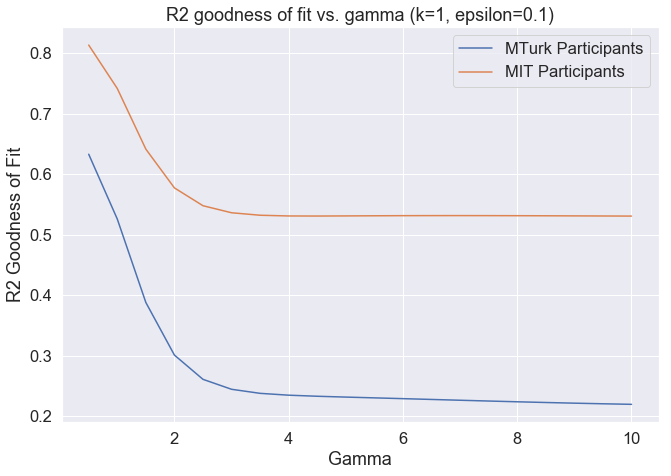

In [196]:
# r2 vs. gamma
k = 1
tremble = 0.1

r2_turk = ALL_R2[(ALL_R2.k == k) & (ALL_R2.tremble == tremble)].sort_values('gamma').reset_index(drop=True)
r2_mit = MIT_R2[(MIT_R2.k == k) & (MIT_R2.tremble == tremble)].sort_values('gamma').reset_index(drop=True)

new_dataframe = pd.DataFrame({'gamma': r2_turk.gamma, 'AMT R2': r2_turk.r2_uniform, 'MIT R2': r2_mit.r2_uniform})


sns.set(rc={'figure.figsize':(10.7,7.27)}, font_scale=1.5)

sns.lineplot(data=new_dataframe, x='gamma', y='AMT R2', legend='full')
p = sns.lineplot(data=new_dataframe, x='gamma', y='MIT R2', legend='full')
p.set(
    xlabel='Gamma',
    ylabel='R2 Goodness of Fit',
    title=u'R2 goodness of fit vs. gamma (k={}, epsilon={})'.format(k, tremble)
)
p.legend(['MTurk Participants', 'MIT Participants'])

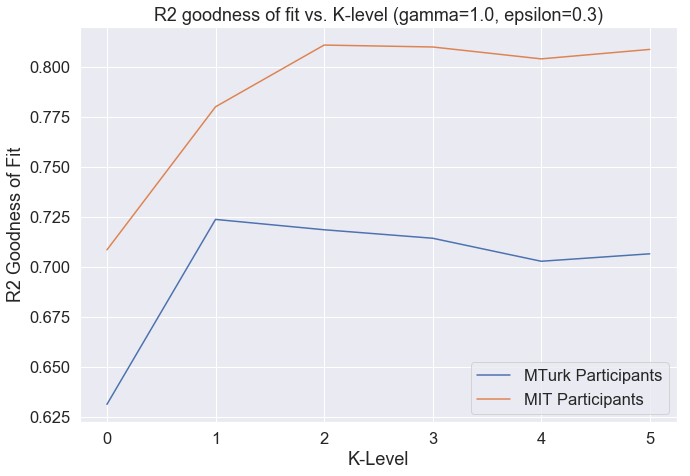

In [231]:
# r2 vs. k
gamma = 1.0
tremble = 0.3

r2_turk = ALL_R2[(ALL_R2.gamma == gamma) & (ALL_R2.tremble == tremble)].sort_values('k').reset_index(drop=True)
r2_mit = MIT_R2[(MIT_R2.gamma == gamma) & (MIT_R2.tremble == tremble)].sort_values('k').reset_index(drop=True)

new_dataframe = pd.DataFrame({'k': r2_turk.k, 'AMT K': r2_turk.r2_uniform, 'MIT K': r2_mit.r2_uniform})


sns.set(rc={'figure.figsize':(10.7,7.27)}, font_scale=1.5)

sns.lineplot(data=new_dataframe, x='k', y='AMT K', legend='full')
p = sns.lineplot(data=new_dataframe, x='k', y='MIT K', legend='full')
p.set(
    xlabel='K-Level',
    ylabel='R2 Goodness of Fit',
    title=u'R2 goodness of fit vs. K-level (gamma={}, epsilon={})'.format(gamma, tremble)
)
p.legend(['MTurk Participants', 'MIT Participants'])

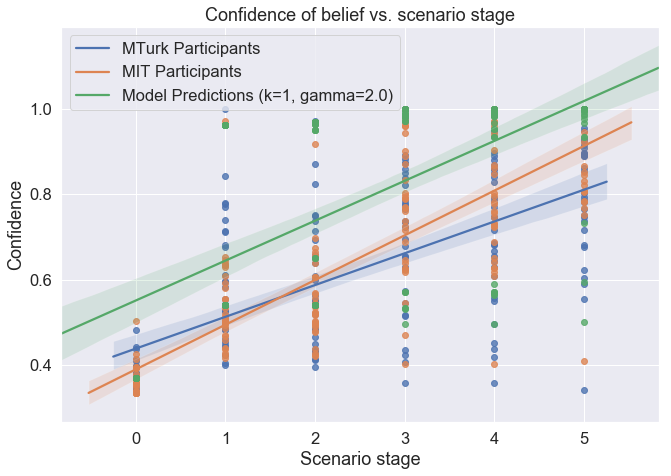

In [242]:
# r2 vs. k
k = 1
gamma = 2.0

mturk_dataframe = pd.DataFrame({
    'game': N_DATA.game,
    'stage': N_DATA.stage,
    'max_belief': N_DATA[['p1', 'p2', 'p3']].max(axis=1)
})

mit_dataframe = pd.DataFrame({
    'game': MIT_DATA.game,
    'stage': MIT_DATA.stage,
    'max_belief': MIT_DATA[['p1', 'p2', 'p3']].max(axis=1)
})

model_pred = MODEL_PREDICTIONS[(MODEL_PREDICTIONS.k == k) & (MODEL_PREDICTIONS.gamma == gamma)]
model_dataframe = pd.DataFrame({
    'game': model_pred.game,
    'stage': model_pred.stage,
    'max_belief': model_pred[['p1', 'p2', 'p3']].max(axis=1)
})


mturk = mturk_dataframe.groupby(['game', 'stage']).mean()
mit = mit_dataframe.groupby(['game', 'stage']).mean()
model = model_dataframe.groupby(['game', 'stage']).mean()

human_df = mturk.join(mit, lsuffix='_mturk', rsuffix='_mit')

new_df = model.join(human_df)
new_df = new_df.reset_index()
sns.set(rc={'figure.figsize':(10.7,7.27)}, font_scale=1.5)

order = 1

sns.regplot(data=new_df, x='stage', y='max_belief_mturk', order=order)
sns.regplot(data=new_df, x='stage', y='max_belief_mit', order=order)
p = sns.regplot(data=new_df, x='stage', y='max_belief', order=order)
p.set(
    xlabel='Scenario stage',
    ylabel='Confidence',
    title=u'Confidence of belief vs. scenario stage'
)
p.legend(['MTurk Participants', 'MIT Participants', 'Model Predictions (k=1, gamma=2.0)'])

In [250]:
MCTS_PREDICTIONS = pd.read_msgpack('../beam_search/mcts_data.msg')

In [251]:
MCTS_PREDICTIONS                                                                                                                                                                                                              

,game,gamma,k,mcts_iter,p1,p2,p3,stage
0,25,1.0,1,1,3.333333e-01,3.333333e-01,3.333333e-01,0
1,25,1.0,1,1,4.652001e-05,4.652001e-05,9.999070e-01,1
2,25,1.0,1,1,5.952569e-15,5.952569e-15,1.000000e+00,2
3,25,1.0,1,1,5.000000e-01,1.897473e-16,5.000000e-01,3
4,25,1.0,1,1,5.000000e-01,5.445899e-43,5.000000e-01,4
5,25,1.0,1,1,5.000000e-01,5.445899e-43,5.000000e-01,5
6,25,1.0,1,5,3.333333e-01,3.333333e-01,3.333333e-01,0
7,25,1.0,1,5,4.652001e-05,4.652001e-05,9.999070e-01,1
8,25,1.0,1,5,5.952569e-15,5.952569e-15,1.000000e+00,2
9,25,1.0,1,5,5.000000e-01,1.897473e-16,5.000000e-01,3


In [253]:
MCTS_ITERS = MCTS_PREDICTIONS.mcts_iter.unique()

r2s = []
for iters in MCTS_ITERS:
    data = MCTS_PREDICTIONS[MCTS_PREDICTIONS.mcts_iter == iters]
    model_data = MODEL_PREDICTIONS[(MODEL_PREDICTIONS.gamma == 1.0) & (MODEL_PREDICTIONS.k == 1)]
    r2s.append(compute_r2_score(data, model_data, 0.0))

print r2s

[(-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754), (-1.3917922344733473, -1.360136999460754)]


In [17]:
N_DATA[(N_DATA.game == 139) & (N_DATA.stage == 5)].mean()

game     139.000000
stage      5.000000
p1         0.339955
p2         0.324764
p3         0.335282
dtype: float64

In [15]:
MIT_DATA[(MIT_DATA.game == 139) & (MIT_DATA.stage == 5)].count()

player    2
game      2
stage     2
p1        2
p2        2
p3        2
dtype: int64